In [52]:
import gpflow
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline
import cartopy.crs as ccrs
import cartopy
import scipy.io as sio
import cartopy.feature as cfeature
import matplotlib.patches as mpatches

## Import Nicole Khans's Dataset

In [53]:
# read in dataset
df = pd.read_csv('HOLSEAdata_120816_ed.csv',  header=None, skiprows=2, names=['ObjectID', 'Dbnum', 'Database', 
                                                                             'Zone', 'Region', 'SubRegion', 'Sample ID', 
                                                                             'Latitude', 'Longitude', 'RSL', 'RSL_er_max',
                                                                             'RSL_er_min', 'Age', 'Age_er_max', 'Age_er_min',
                                                                          'Indicator', 'Indicative meaning'])
# Clean dataframe
dfs = df.drop(columns=['ObjectID', 'Sample ID', 'Indicator', 'Indicative meaning'])
dfs = dfs.replace('\s+', '_',regex=True)
dfs = dfs.replace('\(', '_',regex=True)
dfs = dfs.replace('\)', '_',regex=True)
dfs = dfs.replace('#', '_',regex=True)
dfs = dfs.replace('\.', '_',regex=True)
dfs = dfs.replace(' ', '_', regex=True)
dfs = dfs.replace('&', '_', regex=True)
dfs = dfs.replace('\_+', '_',regex=True)
dfs = dfs.replace(' ', '_', regex=True)

# Create function to turn ages into thousand year increments, and remov
def reduce(x):
    x = x/1000
    return x

# Create function to translate longitude (-180 --> 0) into (180 --> 360)
def longfix(x):
    x[x<0] = x + 360
    return x

def errfix(x):
    x[x<0] = 0
    return x

#apply reduce function to dataframe
dfs[['Age', 'Age_er_max', 'Age_er_min']] = dfs[['Age', 'Age_er_max',
    'Age_er_min']].apply(reduce)

#apply longfix & errfix function to dataframe
dfs[['Longitude']] = dfs[['Longitude']].apply(longfix)
dfs[['Age_er_max', 'Age_er_min', 'RSL_er_max', 'RSL_er_min']] = dfs[['Age_er_max','Age_er_min', 
                                                                     'RSL_er_max', 'RSL_er_min']].apply(errfix)

<big> Import Jonny model & composite outputs </big>

In [54]:
#download files
# !wget https://ndownloader.figshare.com/files/13706690
# !wget https://ndownloader.figshare.com/files/13706663

In [55]:
# Jonny Kingslake/Torsten's Antarctica Ice sheet model
dsj  = xr.open_dataset("/Users/rogercreel/Dropbox/Columbia_PhD/18_19_classes/RCES/RCES_finalproject/jonnymod_112318_1.nc") 
# dsj = xr.open_dataset('13706663')
j_time = dsj.TIME.values
j_LON = dsj.LON.values
j_LAT = dsj.LAT.values
j_esl = dsj.ESL 
j_rsl = dsj.RSL
j_TOPO = dsj.topo

#import file: Ice-6G > -60 latitude (i.e. all except Antarctica) + Torsten's readvance model 
dsc  = xr.open_dataset("/Users/rogercreel/Dropbox/Columbia_PhD/18_19_classes/RCES/RCES_finalproject/ice_6G_Jonny_vars.nc")
# dsc = xr.open_dataset('13706690')
Time_ = dsc.time.values
LON_ = dsc.LON.values 
LAT_ = dsc.LAT.values
esl_ = dsc.esl * -1 
rsl_ = dsc.rsl

Rearrange time variable for comp dataset to read in descending order with values that correspond to **comp** RSL and ESL values

In [56]:
j_time_ = dsj.TIME[::-1].values
comp_time_ = np.zeros(np.size(j_time_))
for i in range(0, np.size(j_time_)):
    if j_time_[i] < 26:
        comp_time_[i] = j_time_[i]      
comp_time_f = comp_time_[260:]
comp_time_k = comp_time_[:260]
comp_time_h = comp_time_k[::-1]
comp_time = np.hstack([comp_time_f, comp_time_h])

Build xarray datasets for two models

In [57]:
jonny = xr.Dataset(
        data_vars={'RSL':    (('time', 'lon', 'lat'), j_rsl),
                   'ESL': (('time'), j_esl),
                   'topo': (('time',  'lon', 'lat'), j_TOPO)},
        coords={'time': j_time,
                'lat': j_LAT,
                'lon': j_LON})

comp = xr.Dataset(
        data_vars={'RSL':    (('time', 'lon', 'lat'), rsl_),
                   'ESL': (('time'), esl_)},
        coords={'time': comp_time,
                'lat': LAT_,
                'lon': LON_})

## Create dataset of "*true*" RSL values from Readvance model output 

<big> Subset Readvance model output at location slice (New Jersey) </big> 

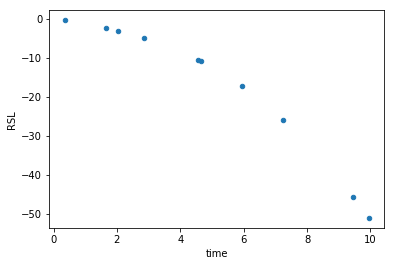

In [58]:
# slice comp dataset for NJ RSL 10kyr - present
NJ = comp.RSL[248:].interp(lat = 39.4, lon = (360-74.4))

# transform to pandas dataframe for random sampling
NJ = NJ.to_dataframe()

#lat & lon columns unnecessary for single lat/lon location
NJ = NJ.drop(columns=['lat', 'lon'])

#take random sample
nnn = 10
NJ_randmod = NJ.sample(nnn).sort_values(by=['time'], ascending=False)
NJ_randmod.reset_index(level=0, inplace=True)
NJ.reset_index(level=0, inplace=True)

# Plot location-subsetted Readvance model output
NJ_randmod.plot.scatter(x='time', y='RSL');

<big> Add Gaussian random noise to both time and RSL </big>

In [59]:
# make random noise for RSL errorbars
mu1, sigma1 = 0, 0.5
RSLnoise = np.random.normal(mu1, sigma1, [nnn,1]) 

# make random noise for time errorbars
mu2, sigma2 = 0, 0.5
t_noise = np.random.normal(mu2, sigma2, [nnn,1])

#make older time measurements less accurate
trend = np.linspace(0.3,1.3,nnn)
timenoise = t_noise + trend.reshape(nnn,1)

# set  smallest time error to 400 years
timenoise[timenoise<0.4] = 0.4

# add noise to NJset
noise = np.append(RSLnoise, t_noise, axis=1)
NJ_randnoise = NJ_randmod + noise

# add noise to time & RSL vectors
Tvals = NJ_randnoise.time.values.reshape(nnn,1)
RSLvals = NJ_randnoise.RSL.values.reshape(nnn,1)

## Construct GP regression with random samples from NJ sea level measurements

<big> Create a GPflow model by instantiating a Gaussian Process Regression (GPR), one of the GPflow model classes.  We’ll make a kernel __[k]__ and instantiate a GPR object using the generated data and the kernel, then optimize the model to get the maximum likelihood.  </big>

In [60]:
# define the covariance function
k = gpflow.kernels.Matern52(1)

# define the model
with gpflow.defer_build():
    m = gpflow.models.GPR(Tvals, RSLvals, kern=k)
    
# build the model
m.compile()

# optimize
opt = gpflow.train.ScipyOptimizer()
opt.minimize(m)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 30.755855
  Number of iterations: 36
  Number of functions evaluations: 41


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 30.755855
  Number of iterations: 36
  Number of functions evaluations: 41


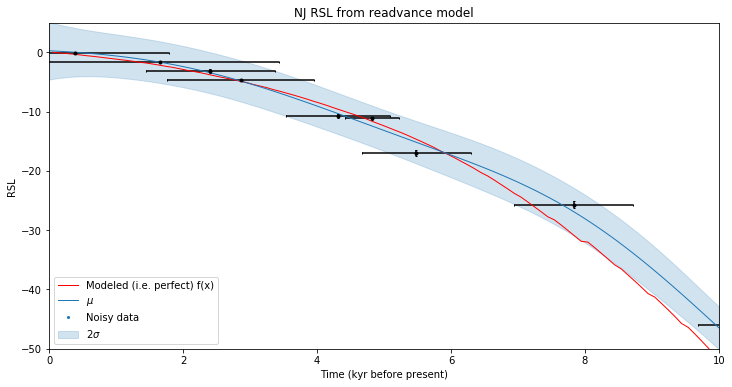

In [61]:
#plot 
def plot(m):
    xx = np.linspace(0, 10, 100).reshape(100, 1)
    mean, var = m.predict_y(xx)
    plt.figure(figsize=(12, 6))
    plt.plot(NJ.time.values, NJ.RSL.values, 'r', lw=1, label='Modeled (i.e. perfect) f(x)')
    plt.plot(xx, mean, 'C0', lw=1, label='$\mu$')
    plt.fill_between(xx[:,0],
                     mean[:,0] - 2*np.sqrt(var[:,0]),
                     mean[:,0] + 2*np.sqrt(var[:,0]),
                     color='C0', alpha=0.2, label='$2\sigma$')
    plt.plot(Tvals, RSLvals, '.', mew=0.1, label='Noisy data')
    plt.errorbar(Tvals, RSLvals, yerr=RSLnoise, xerr=timenoise, fmt='.',  mfc='black',
         mec='black', ecolor='black', capsize=1, capthick=1)

    plt.xlim(0, 10)
    plt.ylim(-50, 5)
    plt.xlabel('Time (kyr before present)')
    plt.ylabel('RSL')
    plt.title('NJ RSL from readvance model')
    plt.legend(loc='lower left')

plot(m)

## We can make a similar GP framework with random samples from NJ sea level measurements

<big> subset SL data for location </big>

In [67]:
# Slice data to New Jersey Coast
NJ = dfs[dfs.SubRegion == 'New_Jersey']

#remove extraneous columns 
    # min and max errors for Age and RSL are identical
    # Lat=(39.1N - 40.4N), Lon=(74.1E-74.7E), but for this exercise we assume they are identical
NJ_ed = NJ.drop(columns=['Dbnum', 'Database', 'Zone', 'Region', 'SubRegion', 
                         'Age_er_min', 'RSL_er_min', 'Latitude', 'Longitude'])
# take random sample
mm = 61
NJ_rand = NJ_ed.sample(mm).reset_index(drop=True)

In [68]:
# reshape age and RSL vectors
time_vals = NJ_rand.Age.values.reshape(mm,1)
time_err = NJ_rand.Age_er_max.values
RSL_vals = NJ_rand.RSL.values.reshape(mm,1)
RSL_err = NJ_rand.RSL_er_max.values


# define the covariance function
k = gpflow.kernels.Matern52(1)

# define the model
with gpflow.defer_build():
    m = gpflow.models.GPR(time_vals, RSL_vals, kern=k)
    
# build the model
m.compile()

# optimize
opt = gpflow.train.ScipyOptimizer()
opt.minimize(m)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 164.853565
  Number of iterations: 23
  Number of functions evaluations: 25


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 164.853565
  Number of iterations: 23
  Number of functions evaluations: 25


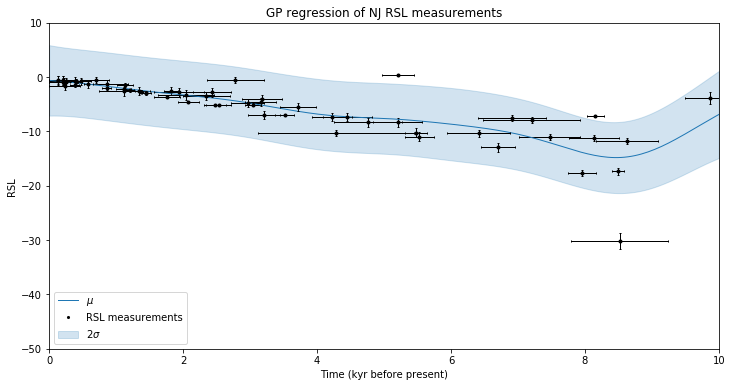

In [73]:
#plot 
def plot(m):
    yy = np.linspace(0, 10, 200).reshape(200, 1)
    
    #mean_f returns the mean and variance of the latent function at points yy
    mean, var = m.predict_y(yy)
    
    plt.figure(figsize=(12, 6))
    plt.plot(yy, mean, 'C0', lw=1, label='$\mu$')
    plt.fill_between(yy[:,0],
                     mean[:,0] - 2*np.sqrt(var[:,0]),
                     mean[:,0] + 2*np.sqrt(var[:,0]),
                     color='C0', alpha=0.2, label='$2\sigma$')
    plt.plot(time_vals, RSL_vals, '.', mew=0.1,  color='black', label='RSL measurements')
    plt.errorbar(time_vals, RSL_vals, yerr=RSL_err, xerr=time_err, fmt='.',  mfc='black',
         mec='black', ecolor='black', capsize=1, capthick=1, elinewidth=1, markeredgewidth=1)

    plt.xlim(0, 10)
    plt.ylim(-50, 10)
    plt.xlabel('Time (kyr before present)')
    plt.ylabel('RSL')
    plt.title('GP regression of NJ RSL measurements')
    plt.legend(loc='lower left')

plot(m);

# Next, we build a spatial GP regression for a single time slice

<big> subset Readvance model output at time slice </big> 

In [74]:
comp_RSL = comp.RSL
comp_agesamp = comp_RSL[comp_RSL.time < 4.5]
comp_samp = comp_agesamp[comp_agesamp.time > 4.4]
 
#Store time value, then remove unnecessary time dimension
slice_time = comp_samp.time.values
comp_samp = comp_samp.squeeze(drop=True)

<big> Interpolate modeled RSL values from sample lat/lon points </big>

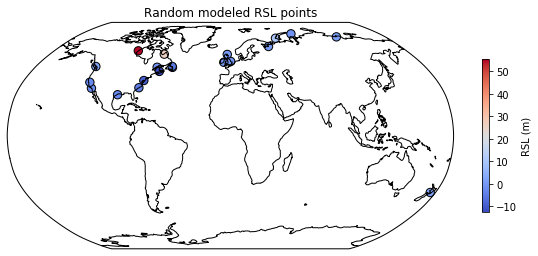

In [75]:
#number of sample points
nn=20

#take random sample from Khan dataset & reset index
rand = dfs.sample(nn)
rand.reset_index(level=0, inplace=True)
randlats = rand.Latitude.get_values()
randlons = rand.Longitude.get_values()
RSLs = np.nan_to_num(rand.RSL.get_values())

# iterate through rand to get interpolated RSL value at comp_samp time (4.47 kyr) for each lat/lon pair 
RSL_interp = []
RSL_sel = {}
for i in range(rand.shape[0]):    
    RSL_sel[i] = comp_samp.interp(lat = randlats[i], lon = randlons[i], method='nearest')
    RSL_interp.append(RSL_sel[i].values.item())
    
#reshape RSL_interp from list into array; all nans into zeros
RSL_interp = np.nan_to_num(np.array(RSL_interp))

# plot interpolated RSL values
fig = plt.figure(figsize=(10, 7))
ax = plt.subplot(projection=ccrs.Robinson())
ax.coastlines()
ax.set_global()
ax.set_title('Random modeled RSL points')
ax = plt.scatter(randlons, randlats, 70, RSL_interp, marker="o", edgecolor='k', 
                  cmap='coolwarm', transform=ccrs.PlateCarree())
cbar = plt.colorbar(ax, shrink=.4, cmap='coolwarm')
cbar.ax.set_ylabel('RSL (m)', rotation=90);

# Construct spatial GP regression from random RSL modeled points

<big> Add spatial noise to RSL points, *only necessary for synthetic data*</big>

In [76]:
# create noise with the same dimension as the dataset 
mu, sigma = 0, 0.1
noise = np.random.normal(mu, sigma, [nn, 1]) 

# add noise to lat, lon
lat_noise = randlats.reshape(nn,1) + noise
lon_noise = randlons.reshape(nn,1) + noise

#add noise to RSL, making sure that any RSL at nan = zero
NOISE = noise.T.squeeze()
RSL_noise = np.nan_to_num(RSL_interp + NOISE)

# Define input space (the globe) with array of Lat and Lon arrays
LAT, LON = np.meshgrid(LAT_, LON_ )
positions = np.vstack([LAT.ravel(), LON.ravel()])
pos_t = (np.array(positions)).T

<big> construct spatial covariance function, first in scikit learn then in GPflow.  </big>

In [77]:
from itertools import product
from mpl_toolkits.mplot3d import Axes3D
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, Matern

In [78]:
# stack noisy lat and lon into lat/lon pairs
gridstack =  np.column_stack((lon_noise, lat_noise)) 

# define covariance function
kernel = Matern(15, (20, 250), 2.5) # * RBF([1,1], (1, 1e4)) #* C(1.0, (1e-3, 1e3)) 
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5)

# fit function with noisy RSL 
gp.fit(gridstack, RSL_noise)

# extract GP predictions for each grid point
RSLp = gp.predict(pos_t).reshape(512,256)

<big> Plot points </big>

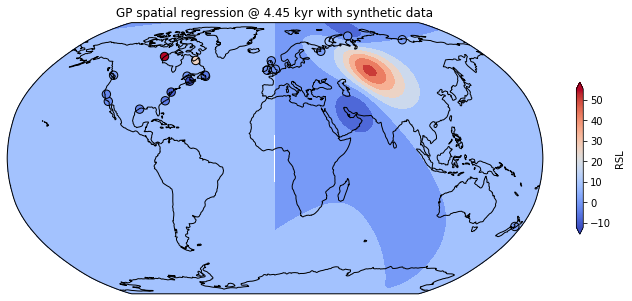

In [79]:
#plot training points vs. GP prediction
fig = plt.figure(figsize=(12, 7))
ax = plt.subplot(projection=ccrs.Robinson())
ax.coastlines()
ax.set_title('GP spatial regression at time 4.47 kyr ')

#plot GP regression
ax = plt.contourf(LON, LAT, RSLp, transform=ccrs.PlateCarree(), cmap='coolwarm')

#plot random RSL training points
ax = plt.scatter(randlons, randlats, 70, RSL_interp, marker="o", edgecolor='k', 
                 cmap='coolwarm', transform=ccrs.PlateCarree())
cbar = plt.colorbar(ax, shrink=.4, cmap='coolwarm', extend='both')
cbar.ax.set_ylabel('RSL', rotation=90);
plt.title('GP spatial regression @ %0.2f kyr with synthetic data' % np.around(slice_time, 2));


# Construct spatial GP regression from random subset of RSL SLIPs 

<big> construct spatial covariance function </big>

In [80]:
# stack noisy lat and lon into lat/lon pairs
gridstack =  np.column_stack((randlons, randlats)) 

# define covariance function
kernel = Matern(100, (100, 2500), 2.5) + RBF([1,1], (100, 1e4)) + C(1.0, (1e-3, 1e3)) 
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5)

# fit function with noisy RSL 
gp.fit(gridstack, RSLs)

# extract GP predictions for each grid point
RSLp = gp.predict(pos_t).reshape(512,256)

<big> Plot points </big>

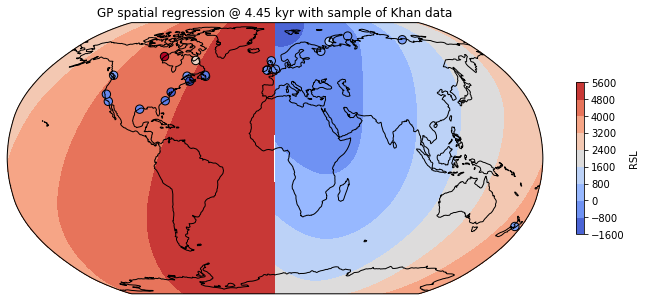

In [81]:
#plot training points vs. GP prediction
fig = plt.figure(figsize=(12, 7))
ax = plt.subplot(projection=ccrs.Robinson())
ax.coastlines()

#plot GP regression
ax1 = plt.contourf(LON, LAT, RSLp, transform=ccrs.PlateCarree(), cmap='coolwarm')

#plot random RSL training points
ax = plt.scatter(randlons, randlats, 70, RSL_interp, marker="o", edgecolor='k', 
                 cmap='coolwarm', transform=ccrs.PlateCarree())
cbar = plt.colorbar(ax1, shrink=.4, cmap='coolwarm', extend='both')
cbar.ax.set_ylabel('RSL', rotation=90);
plt.title('GP spatial regression @ %0.2f kyr with sample of Khan data' % np.around(slice_time, 2));

# GPflow
### Spatial GP regression from random modeled RSLs 

In [82]:
# set variance, lengthscale, and dimensions
inDim=2
Vf = np.array([1])
length = np.array([0.5, 1.5])

# set lower and upper limits
lowerBounds = np.array([0.,1.])
upperBounds = np.array([1., 2.])

# define the covariance function
k1 = gpflow.kernels.Matern52(input_dim=inDim, variance=Vf, lengthscales=length, ARD=True)
k = k1

#tensorflow has a static graph, so to change priors we reset it, then compile
m.clear()
m.kern.variance.prior = gpflow.priors.Gaussian(0,0.2)

# Change transforms
m.kern.lengthscales.transform = gpflow.transforms.Logistic(np.min(lowerBounds), np.max(upperBounds))

m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/lengthscales,Parameter,None,"[0.0, 2.0]",True,(),True,2.499449975694239
GPR/kern/variance,Parameter,"N(0.0,0.2)",+ve,True,(),True,52.53221378664616
GPR/likelihood/variance,Parameter,None,+ve,True,(),True,9.164656085580383


In [83]:
# define the model
with gpflow.defer_build():
    m = gpflow.models.GPR(gridstack, RSL_noise.reshape(nn,1), kern=k) 

# build the model
m.compile()

# optimize
opt = gpflow.train.ScipyOptimizer()
opt.minimize(m)

# mean, var = m.predict_y(np.array([np.reshape(LON,(-1,)).T,np.reshape(LAT,(-1,))]).T)
mean, var = m.predict_f(pos_t)
mean=mean.reshape(512,256)
var=var.reshape(512,256)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 74.571534
  Number of iterations: 40
  Number of functions evaluations: 54


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 74.571534
  Number of iterations: 40
  Number of functions evaluations: 54


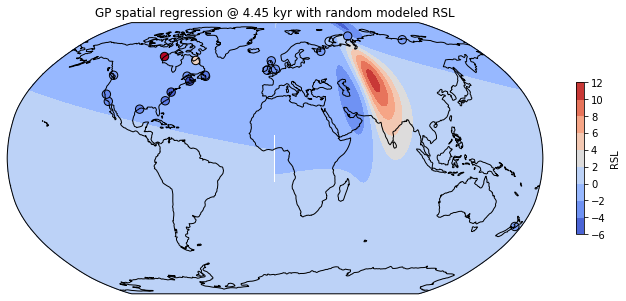

In [84]:
#plot training points vs. GP prediction
fig = plt.figure(figsize=(12, 7))
ax = plt.subplot(projection=ccrs.Robinson())
ax.coastlines()

#plot GP regression
ax1 = plt.contourf(LON, LAT, mean, transform=ccrs.PlateCarree(), cmap='coolwarm')

#plot random RSL training points
ax = plt.scatter(randlons, randlats, 70, RSL_interp, marker="o", edgecolor='k', 
                 cmap='coolwarm', transform=ccrs.PlateCarree())
cbar = plt.colorbar(ax1, shrink=.4, cmap='coolwarm', extend='both')
cbar.ax.set_ylabel('RSL', rotation=90);
plt.title('GP spatial regression @ %0.2f kyr with random modeled RSL' % np.around(slice_time, 2));

In [36]:
m.read_trainables()

{'GPR/kern/lengthscales': array([1.04776880e+01, 1.14799975e-04]),
 'GPR/kern/variance': array([340.02433963]),
 'GPR/likelihood/variance': array(0.00204023)}

Useful links for GPflow:
resetting kernels:  https://github.com/GPflow/GPflow/issues/719

setting hyperparameters (or not): https://github.com/GPflow/GPflow/issues/404

sampling from priors:  https://github.com/GPflow/GPflow/issues/838


gpflow docs on kernels:  https://gpflow.readthedocs.io/en/latest/notebooks/kernels.html

gpflow docs on what one can do with each kernel:  https://gpflow.readthedocs.io/en/master/options.html

gpflow docs on models https://gpflow.readthedocs.io/en/latest/notebooks/models.html

gpflow docs on priors:  https://gpflow.readthedocs.io/en/master/_modules/gpflow/priors.html

multidimensional example (3D in, 1D out) using GPflow: http://www-users.york.ac.uk/~dp626/shared/GPflow_multiinput_example.html

discussion of ARD: https://github.com/GPflow/GPflow/issues/401